In [13]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# set seed to reproduce similar results
np.random.seed(0)

In [18]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial_Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/takea/Desktop/DeepLearning/datasets/week3/HAR_Dataset/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/takea/Desktop/DeepLearning/datasets/week3/HAR_Dataset/UCI_HAR_Dataset/')

    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [19]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [20]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


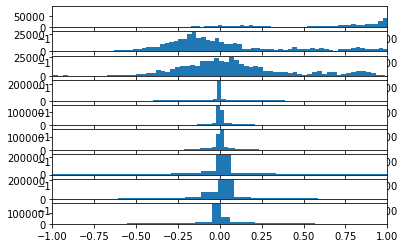

In [21]:
# plot distributions
plot_distributions(trainX)

In [22]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [23]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 78s 577ms/step - loss: 1.1967 - accuracy: 0.4885 - val_loss: 1.0209 - val_accuracy: 0.5887
Epoch 2/10
92/92 [==============================] - 46s 499ms/step - loss: 0.8226 - accuracy: 0.6495 - val_loss: 0.8727 - val_accuracy: 0.7213
Epoch 3/10
92/92 [==============================] - 51s 551ms/step - loss: 0.5964 - accuracy: 0.7517 - val_loss: 0.7690 - val_accuracy: 0.7369
Epoch 4/10
92/92 [==============================] - 53s 574ms/step - loss: 0.4389 - accuracy: 0.8274 - val_loss: 0.6494 - val_accuracy: 0.8389
Epoch 5/10
92/92 [==============================] - 50s 546ms/step - loss: 0.3331 - accuracy: 0.8871 - val_loss: 0.5607 - val_accuracy: 0.8702
Epoch 6/10
92/92 [==============================] - 47s 509ms/step - loss: 0.3278 - accuracy: 0.8808 - val_loss: 0.5478 - val_accuracy: 0.8355
Epoch 7/10
92/92 [==============================] - 48s 521ms/step - loss: 0.2474 - accuracy: 0.9145 - val_loss: 0.4758 - val_accuracy: 0.8783

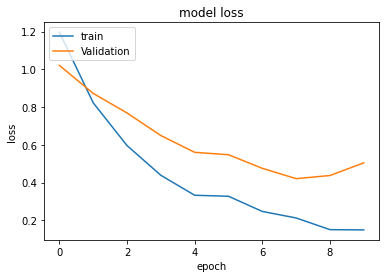

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [27]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8876823782920837
93/93 [==============================] - 17s 133ms/step


In [28]:
predictions

array([[2.5056265e-04, 2.8136425e-04, 4.2672349e-07, 2.6968189e-03,
        9.9677026e-01, 5.8442225e-07],
       [1.9902944e-04, 2.1936356e-04, 3.1478658e-07, 2.4010213e-03,
        9.9717987e-01, 4.2474207e-07],
       [1.9266142e-04, 2.1758089e-04, 2.9144834e-07, 2.2219140e-03,
        9.9736720e-01, 3.9293533e-07],
       ...,
       [9.9365669e-04, 9.9785560e-01, 1.1262780e-03, 4.0018364e-07,
        2.3750474e-05, 3.0578536e-07],
       [1.8977338e-03, 9.9734157e-01, 6.6019309e-04, 1.8795072e-06,
        9.6184522e-05, 2.3339951e-06],
       [8.2443043e-04, 9.9893612e-01, 2.0930980e-04, 2.5734951e-07,
        2.9474726e-05, 3.7191168e-07]], dtype=float32)

In [29]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[485   3   8   0   0   0]
 [ 14 421  36   0   0   0]
 [  6  16 398   0   0   0]
 [  1  21   0 417  49   3]
 [  2   0   0 129 401   0]
 [  0  27  16   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       496
           2       0.86      0.89      0.88       471
           3       0.87      0.95      0.91       420
           4       0.76      0.85      0.80       491
           5       0.89      0.75      0.82       532
           6       0.99      0.92      0.96       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



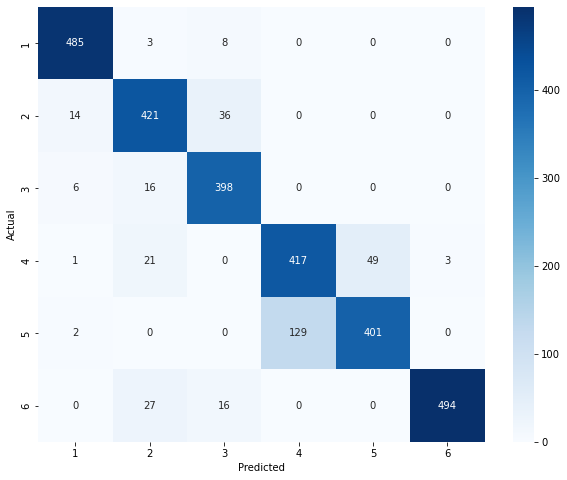

In [30]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [31]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 21s 146ms/step - loss: 0.4947 - accuracy: 0.7953 - val_loss: 0.3905 - val_accuracy: 0.8967
Epoch 2/20
92/92 [==============================] - 11s 116ms/step - loss: 0.1543 - accuracy: 0.9413 - val_loss: 0.2856 - val_accuracy: 0.9089
Epoch 3/20
92/92 [==============================] - 10s 114ms/step - loss: 0.1147 - accuracy: 0.9532 - val_loss: 0.2870 - val_accuracy: 0.9123
Epoch 4/20
92/92 [==============================] - 11s 116ms/step - loss: 0.0943 - accuracy: 0.9572 - val_loss: 0.3007 - val_accuracy: 0.9048
Epoch 5/20
92/92 [==============================] - 11s 116ms/step - loss: 0.0870 - accuracy: 0.9616 - val_loss: 0.2810 - val_accuracy: 0.9137
Epoch 6/20
92/92 [==============================] - 11s 115ms/step - loss: 0.0882 - accuracy: 0.9563 - val_loss: 0.2705 - val_accuracy: 0.9116
Epoch 7/20
92/92 [==============================] - 10s 112ms/step - loss: 0.0798 - accuracy: 0.9609 - val_loss: 0.2837 - val_accuracy: 0.9103

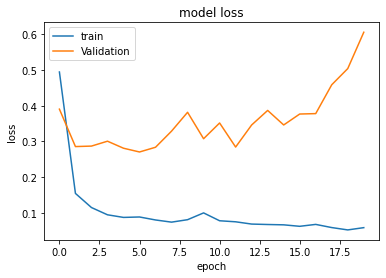

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [35]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.8887003660202026
93/93 [==============================] - 5s 24ms/step


**** Confusion Matrix ****
[[432   3  61   0   0   0]
 [  1 414  56   0   0   0]
 [  0   0 420   0   0   0]
 [  1  25   0 424  41   0]
 [  3   6   2  86 435   0]
 [  0  27  16   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.87      0.93       496
           2       0.87      0.88      0.88       471
           3       0.76      1.00      0.86       420
           4       0.83      0.86      0.85       491
           5       0.91      0.82      0.86       532
           6       1.00      0.92      0.96       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



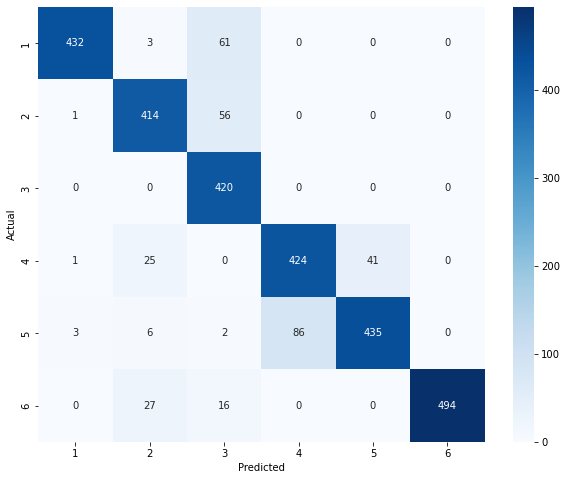

In [36]:
display_results(testy,predictions,classNames)

In [37]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [38]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 235ms/step


In [39]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
